In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit
import ciw
import collections

# Define the model

![model](imgs/visualised_model.png)

In [3]:
def build_model(lambda_a, lambda_o, mu, total_capacity):
    """ Builds the required ciw network

    Parameters
    ----------
    lambda_a : [float]
        [Arrival rate of ambulance patients]
    lambda_o : [float]
        [Arrival rate of other patients]
    mu : [float]
        [Service rate of hospital]
    total_capacity : [integer]
        [The total capacity of the hospital]
    """          
    model = ciw.create_network(
        arrival_distributions = [ciw.dists.Exponential(lambda_a),
                                 ciw.dists.Exponential(lambda_o)],
        service_distributions = [ciw.dists.Deterministic(0),
                                 ciw.dists.Exponential(mu)],
        routing=[[0.0, 1.0],
                 [0.0, 0.0]],
        number_of_servers=[float('inf'), total_capacity]
    )
    return model

# Inherit 'ciw.Node' class to block individuals of Node 1

![smart_model](imgs/visualised_smart_model.png)

In [4]:
def build_custom_node(threshold=8):
    """Build a custome node to replace the default ciw.Node
    
    Parameters
    ----------
    threshold : [int], optional
        [The capacity threshold to be used by the method, by default 8]
    
    Returns
    -------
    [class]
        [A custom node class that inherits from ciw.Node]
    """    
    class CustomNode(ciw.Node):
        def finish_service(self):
            """
            The next individual finishes service:
              - finds the individual to finish service
              - check if they need to change class
              - find their next node
              - release the individual if there is capacity at destination,
                otherwise cause blockage
              - note that blockage also occurs when we are at node 1 and the 
                number of individuals on node 2 are more than the 'thershold'
            """
            next_individual, next_individual_index = self.find_next_individual()
            self.change_customer_class(next_individual)
            next_node = self.next_node(next_individual)
            next_individual.destination = next_node.id_number

            if not np.isinf(self.c):
                next_individual.server.next_end_service_date = float('Inf')
            
            blockage = (next_node.number_of_individuals > threshold and self.id_number == 1)
            if (next_node.number_of_individuals < next_node.node_capacity) and not blockage:
                self.release(next_individual_index, next_node)
                # print(self.id_number, next_node.number_of_individuals)
            else:
                self.block_individual(next_individual, next_node)
                # print(next_node.number_of_individuals)
    return CustomNode

# Simulate the problem

In [5]:
def simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold = 8, seed_num = None):
    """Simulate the model
    
    Parameters
    ----------
    seed_num : [float], optional
        [A seed number in order to be able to replicate results], by default random.random()
    
    Returns
    -------
    [object]
        [An object that contains all simulation records]
    """    
    if seed_num == None:
        seed_num = random.random()
        
    model = build_model(lambda_a, lambda_o, mu, total_capacity)
    node = build_custom_node(threshold)

    ciw.seed(seed_num)
    
    simulation = ciw.Simulation(model, node_class=node)
    simulation.simulate_until_max_time(1440)
    
    return simulation

In [52]:
lambda_a = 0.1       # Ambulance: 6 arrivals per hour
lambda_o = 0.05      # Others: 3 arrivals per hour
mu = 0.05            # Service time: 3 services per hour
total_capacity = 8   # Number of servers: 8 servers
threshold = 4        # Threshold of accepting ambulance patients

records = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, 1).get_all_records()
blocks = [b.time_blocked for b in records]
np.mean(blocks)

0.4184074029967902

# Timing Experiment 1

In [11]:
def time_for_different_number_of_trials(num_of_trials):
    times = []
    for trials in range(num_of_trials):
        duration_object = timeit.Timer("simulate_model(0.15, 0.2, 0.05, 8, 4)", 
                          "from __main__ import simulate_model")
        duration_for_trial = duration_object.timeit(number=trials)
        times.append(duration_for_trial)
        #print(trials, duration_for_trial)
            
    time_plot = plt.plot(times)
    time_plot = plt.xlabel("Number of Trials")
    time_plot = plt.ylabel("Time in seconds")
    
    return [times,time_plot]

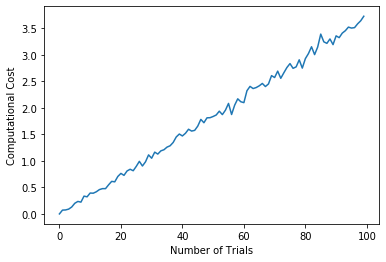

In [17]:
times = time_for_different_number_of_trials(100)[0]
plt.show()

# Timing Experiment 2 - (Confidence Intervals)

### Method 1

In [18]:
def get_multiple_runs_results(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials=10):
    
    warm_up_time = 100
    records = collections.namedtuple('records', 'waiting_times service_times blocking_times')
    results = []
    
    for trial in range(num_of_trials):
        simulation = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, random.random())
        sim_results = simulation.get_all_records()

        waiting = [r.waiting_time for r in sim_results if r.arrival_date > warm_up_time]
        serving = [r.service_time for r in sim_results if r.arrival_date > warm_up_time]
        blocking = [r.time_blocked for r in sim_results if r.arrival_date > warm_up_time]

        results.append(records(waiting, serving, blocking))
        
    return results

In [19]:
def waiting_time_confidence_intervals_for_different_number_of_trials(num_of_trials = 10):

    aggregated_waits = [[] for _ in range(num_of_trials)]
    results = get_multiple_runs_results(0.15, 0.2, 0.05, 8, 4, num_of_trials)
    all_waits = [w.waiting_times for w in results]
    
    for i in range(len(all_waits)):
        for j in range(i):
            aggregated_waits[i] += all_waits[j]
    
    print([len(w) for w in aggregated_waits])
    plot = plt.boxplot(aggregated_waits, whis = 1, showfliers = False)

    return plot

[0, 631, 1257, 1981, 2640, 3281, 3960, 4607, 5315, 5934, 6593, 7226, 7867, 8507, 9259, 9916, 10580, 11237, 11893, 12591]


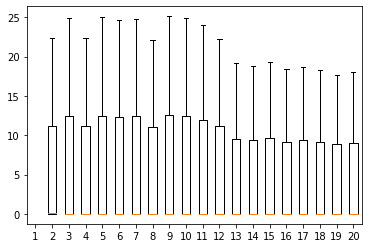

In [20]:
waiting_time_confidence_intervals_for_different_number_of_trials(20)
plt.show()

In [ ]:
lambda_a = 0.1
lambda_o = 0.05   
mu = 0.05 
total_capacity = 8 
threshold = 8 

In [50]:
results = get_multiple_runs_results(lambda_a, lambda_o, mu, total_capacity, 4, 1)

print(np.mean([np.mean(w.waiting_times) for w in results]))
print(np.mean([np.mean(s.service_times) for s in results]))
print(np.mean([np.mean(b.blocking_times) for b in results]))

0.0
11.889336020467518
0.5859700549626834


# Results of the model

In [24]:
lambda_a = 0.1
lambda_o = 0.05   
mu = 0.05 
total_capacity = 8 
threshold = 8        

In [25]:
simulation = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, 1)
sim_results = simulation.get_all_records()

In [26]:
# Mean Waiting Time
waits = [r.waiting_time for r in sim_results]
mean_waiting_time = sum(waits) / len(waits)
mean_waiting_time

0.009549642336239419

In [27]:
# Services in each node
service_nodes = [r.node for r in sim_results]
collections.Counter(service_nodes)

Counter({1: 152, 2: 224})

In [205]:
# Mean Time Blocked
Blocks = [r.time_blocked for r in sim_results]
mean_time_blocked = sum(Blocks) / len(Blocks)
mean_time_blocked

1.401489260432193

# Timing Experiment 2 - (Confidence Intervals)

In [ ]:
def waiting_time_confidence_intervals_for_different_number_of_trials(trials_to_be_checked = 10):

    all_waiting_times = [[] for _ in range(trials_to_be_checked)]
    for number_of_trials in range(trials_to_be_checked):
        results = get_multiple_runs_results(0.15, 0.2, 0.05, 8, 4, number_of_trials)
        current_waiting_times = [w.waiting_times for w in results]

        for wait in range(len(current_waiting_times)):
            all_waiting_times[number_of_trials] += current_waiting_times[wait]
        
    return all_waiting_times

demo = waiting_time_confidence_intervals_for_different_number_of_trials(20)

plt.boxplot(demo, whis = 1, showfliers = False)
plt.show()

# Examples for testing

In [168]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))

290
1089.854729732795
0.0


In [169]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1), node_class=build_custom_node(7))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))

290
1026.2910789050652
66.03415121579033


In [170]:
sim_results = []
for i in range(10):
    simulation = simulate_model(0.15, 0.2, 0.05, 8, 4, i)
    sim_results.append(len(simulation.get_all_records()))

In [171]:
sim_results

[705, 647, 712, 747, 681, 738, 699, 724, 744, 700]